In [1]:
import pandas as pd
import numpy as np
#from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
jnj = pd.read_excel('~/capp30254_fight_potatoes/data processing/data_processed_v2_0513.xlsx', sheet_name='JNJ')
abt = pd.read_excel('~/capp30254_fight_potatoes/data processing/data_processed_v2_0513.xlsx', sheet_name='ABT')

In [3]:
# Some separation into train/test
jnj_train = jnj[jnj['Report Date'] < '2022-01-01']
jnj_test = jnj[jnj['Report Date'] >= '2022-01-01']
abt_train = abt[abt['Report Date'] < '2022-01-01']
abt_test = abt[abt['Report Date'] >= '2022-01-01']
test_dates = jnj_test['Report Date']

/var/folders/bq/y6jssnk56235t8wjc47m1fdw0000gn/T/ipykernel_72187/1076450576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jnj_train['diff'] = jnj_train['Stock price'].diff()


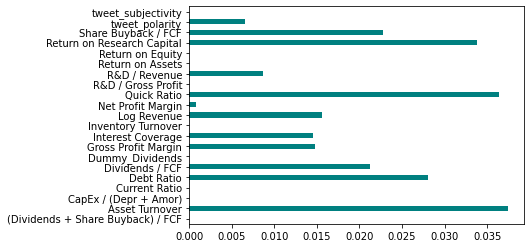

In [4]:
# feature selection for JNJ
jnj_train['diff'] = jnj_train['Stock price'].diff()
X_jnj = jnj_train.iloc[:, 3: -1]
Y_jnj_price = jnj_train['Stock price']
Y_jnj = np.where(jnj_train['diff'] >= 0, 1, 0)
importances = mutual_info_classif(X_jnj, Y_jnj, random_state=1241)
feat_importances_jnj = pd.Series(importances, jnj_train.columns[3: -1])
feat_importances_jnj.plot(kind='barh', color ="teal")
plt.show()

/var/folders/bq/y6jssnk56235t8wjc47m1fdw0000gn/T/ipykernel_72187/2988129769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_train['diff'] = abt_train['Stock price'].diff()


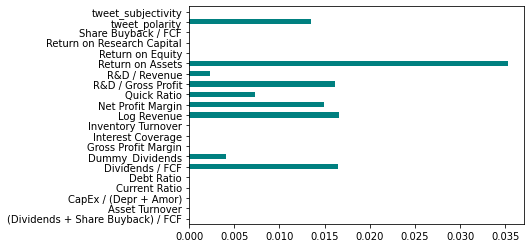

In [5]:
# feature selection for ABT
abt_train['diff'] = abt_train['Stock price'].diff()
X_abt = abt_train.iloc[:, 3: -1]
Y_abt_price = abt_train['Stock price']
Y_abt = np.where(abt_train['diff'] >= 0, 1, 0)
importances = mutual_info_classif(X_abt, Y_abt, random_state=1241)
feat_importances_abt = pd.Series(importances, abt_train.columns[3: -1])
feat_importances_abt.plot(kind='barh', color ="teal")
plt.show()

In [6]:
# subset cols deemed 'relevant'
# jnj
feat_jnj = feat_importances_jnj.to_frame('importance')
feat_jnj = feat_jnj[feat_jnj['importance'] > 0]
jnj_lst = list(feat_jnj.index)
X1_jnj = X_jnj[np.intersect1d(X_jnj.columns, jnj_lst)]
jnj_test['diff'] = jnj_test['Stock price'].diff()
Y_jnj_true_price = jnj_test['Stock price']
Y_jnj_true = np.where(jnj_test['diff'] >= 0, 1, 0)
jnj_test = jnj_test[np.intersect1d(jnj_test.columns, jnj_lst)]

# abt
feat_abt = feat_importances_abt.to_frame('importance')
feat_abt = feat_abt[feat_abt['importance'] > 0]
abt_lst = list(feat_abt.index)
X1_abt = X_abt[np.intersect1d(X_abt.columns, abt_lst)]
abt_test['diff'] = abt_test['Stock price'].diff()
Y_abt_true_price = abt_test['Stock price']
Y_abt_true = np.where(abt_test['diff'] >= 0, 1, 0)
abt_test = abt_test[np.intersect1d(abt_test.columns, abt_lst)]

/var/folders/bq/y6jssnk56235t8wjc47m1fdw0000gn/T/ipykernel_72187/703275229.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jnj_test['diff'] = jnj_test['Stock price'].diff()
/var/folders/bq/y6jssnk56235t8wjc47m1fdw0000gn/T/ipykernel_72187/703275229.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_test['diff'] = abt_test['Stock price'].diff()


In [7]:
# baseline logit
# jnj
lr_jnj = LogisticRegression(solver = 'lbfgs', random_state=1241)
lr_jnj.fit(X1_jnj, Y_jnj)
pred_jnj = lr_jnj.predict(jnj_test)
score_jnj = lr_jnj.score(jnj_test, Y_jnj_true)

# abt
lr_abt = LogisticRegression(solver = 'lbfgs', random_state=1241)
lr_abt.fit(X1_abt, Y_abt)
pred_abt = lr_abt.predict(abt_test)
score_abt = lr_abt.score(abt_test, Y_abt_true)

score_jnj, score_abt

(0.5350877192982456, 0.4473684210526316)

In [8]:
# sgd regression
# jnj
sgdr_j = SGDRegressor(alpha=0.0001, epsilon=0.01, eta0=0.46, penalty='elasticnet', random_state=125)
sgdr_j.fit(X1_jnj, Y_jnj_price)

score = sgdr_j.score(X1_jnj, Y_jnj_price)
print("R-squared:", score)

ypred_j = sgdr_j.predict(jnj_test)

mse = mean_squared_error(Y_jnj_true_price, ypred_j)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

# abt
sgdr_a = SGDRegressor(alpha=0.0001, epsilon=0.01, eta0=0.01, penalty='elasticnet', random_state=123)
sgdr_a.fit(X1_abt, Y_abt_price)

score = sgdr_a.score(X1_abt, Y_abt_price)
print("R-squared:", score)

ypred_a = sgdr_a.predict(abt_test)

mse = mean_squared_error(Y_abt_true_price, ypred_a)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))


R-squared: -1.507959113419493e+27
MSE:  7.430803085445842e+29
RMSE:  862021060383436.5
R-squared: 0.7035705864282196
MSE:  56.05435625307257
RMSE:  7.486945722594266


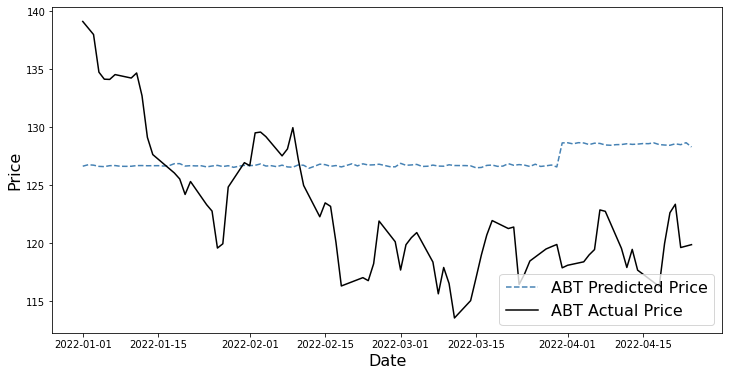

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

#ax.plot(test_dates, ypred_j, color="steelblue", label='JNJ Predicted Price', ls = 'dashed')
#ax.plot(test_dates, Y_jnj_true_price, color="grey", label='JNJ Actual Price')
ax.plot(test_dates, ypred_a, color="steelblue", label='ABT Predicted Price', ls = 'dashed')
ax.plot(test_dates, Y_abt_true_price, color="black", label='ABT Actual Price')
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Date", fontsize=16)
ax.set_ylabel("Price", fontsize=16)
plt.show()

In [10]:
# sgd classifier (logit w/ SGD)
# jnj
sgdc_j = SGDClassifier(alpha=0.0001, epsilon=0.01, eta0=0.5, random_state=12345)
sgdc_j.fit(X1_jnj, Y_jnj)

score = sgdc_j.score(X1_jnj, Y_jnj)
print("R-squared:", score)

ypred_j = sgdc_j.predict(jnj_test)

mse = mean_squared_error(Y_jnj_true, ypred_j)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))
print("Score: ", sgdc_j.score(jnj_test, Y_jnj_true))

# abt
sgdc_a = SGDClassifier(alpha=0.0001, epsilon=0.01, eta0=0.5, random_state=12346)
sgdc_a.fit(X1_jnj, Y_jnj)

score = sgdc_a.score(X1_jnj, Y_jnj)
print("R-squared:", score)

ypred_a = sgdc_a.predict(jnj_test)

mse = mean_squared_error(Y_jnj_true, ypred_a)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))
print("Score: ", sgdc_a.score(jnj_test, Y_jnj_true))

R-squared: 0.5022354694485842
MSE:  0.42105263157894735
RMSE:  0.6488856845230502
Score:  0.5789473684210527
R-squared: 0.4977645305514158
MSE:  0.5789473684210527
RMSE:  0.7608859102526822
Score:  0.42105263157894735
